# Project 03: Decision Tree


## Import Libraries


In [1]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
from constants.path import DATA_WDBC, DATA_WINE, DATA_CARS


## Dataset Loading and Preprocessing


In [3]:
with open(DATA_WDBC, "r") as f:
    header = f.readline().strip().strip('"')  # Remove quotes
    columns = header.split(",")  # Split into column names

# Step 2: Load data with corrected columns
breast_df = pd.read_csv(DATA_WDBC, skiprows=1, header=None, names=columns)

# Step 3: Map labels (M=0, B=1) to align with sklearn's encoding
print("Unique Diagnosis values:", breast_df["Diagnosis"].unique())
breast_df = breast_df[breast_df["Diagnosis"].isin(["M", "B"])]
y_breast = breast_df["Diagnosis"].map({"M": 0, "B": 1})
X_breast = breast_df.drop("Diagnosis", axis=1)

# Verify dataset integrity
print("Number of features:", X_breast.shape[1])
print("Feature Names:\n", len(X_breast.columns.tolist()), (X_breast.columns.tolist()))
print("\nClass Distribution:\n", y_breast.value_counts())


Unique Diagnosis values: ['M' 'B']
Number of features: 30
Feature Names:
 30 ['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']

Class Distribution:
 Diagnosis
1    357
0    212
Name: count, dtype: int64


In [4]:
wine_df = pd.read_csv(DATA_WINE, sep=",")
# Group into 3 quality categories
wine_df["quality_group"] = pd.cut(
    wine_df["quality"], bins=[-1, 4, 6, 10], labels=["Low", "Standard", "High"]
)

# Verify class distribution
print("Quality Group Distribution:")
print(wine_df["quality_group"].value_counts())

# Prepare features and labels
X_wine = wine_df.drop(["quality", "quality_group"], axis=1)
y_wine = wine_df["quality_group"]


Quality Group Distribution:
quality_group
Standard    3655
High        1060
Low          183
Name: count, dtype: int64


In [ ]:
"""
Additional Dataset Recommendation: Car Evaluation Dataset
This dataset meets all project requirements:

Source: UCI Machine Learning Repository

Classes: 4 (unacc, acc, good, vgood)

Samples: 1728

Features: 6 categorical attributes (buying price, maintenance cost, doors, etc.).
"""

# Load Car Evaluation Dataset
column_names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
car_df = pd.read_csv(DATA_CARS, header=None, names=column_names)

# One-Hot Encode Categorical Features
X_car = pd.get_dummies(car_df.drop("class", axis=1))
y_car = car_df["class"]

# Verify Dataset Compliance
print(f"Total Samples: {len(car_df)}")  # Output: 1728
print("Class Distribution:\n", y_car.value_counts())

# Class Distribution (Example Output):
# unacc    1210
# acc       384
# good       69
# vgood      65


## Data Splitting and Visualization


In [5]:
def split_and_visualize(X, y, dataset_name):
    ratios = [0.4, 0.6, 0.8, 0.9]
    for ratio in ratios:
        # Stratified split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=ratio, stratify=y, shuffle=True, random_state=42
        )

        # Class distribution visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        (
            pd.Series(y)
            .value_counts(normalize=True)
            .plot(kind="bar", ax=axes[0], title=f"Original ({len(y)} samples)")
        )
        (
            pd.Series(y_train)
            .value_counts(normalize=True)
            .plot(kind="bar", ax=axes[1], title=f"Train ({len(y_train)} samples)")
        )
        (
            pd.Series(y_test)
            .value_counts(normalize=True)
            .plot(kind="bar", ax=axes[2], title=f"Test ({len(y_test)} samples)")
        )

        plt.suptitle(
            f"{dataset_name} - {ratio * 100:.0f}/{100 - ratio * 100:.0f} Split"
        )
        plt.tight_layout()
        plt.savefig(f"class_dist_{dataset_name}_ratio_{ratio}.png")
        plt.show()


## Decision Tree Training and Evaluation


In [6]:
def train_evaluate_decision_tree(
    X_train,
    y_train,
    X_test,
    y_test,
    dataset_name,
    split_ratio,
):
    # Dynamically set feature and class names
    feature_names = X_train.columns.tolist()  # Fixes "30 vs. 11 features" error
    class_names = np.unique(y_train).tolist()  # Fixes class count mismatch

    # Train model
    clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
    clf.fit(X_train, y_train)

    # Predictions
    y_pred = clf.predict(X_test)

    # Classification Report (with validation)
    print(
        f"\nClassification Report ({dataset_name}, {split_ratio * 100:.0f}/{100 - split_ratio * 100:.0f}):"
    )
    print(
        classification_report(
            y_test,
            y_pred,
            target_names=class_names,
            labels=np.unique(y_test),  # Ensure alignment with actual classes
        )
    )

    # Confusion Matrix Heatmap (fixes "index 2 out of bounds")
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        annot=True,
        fmt="d",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.savefig(f"confusion_matrix_{dataset_name}_ratio_{split_ratio}.png")
    plt.show()

    # Export trees only if classes and features are valid
    if split_ratio == 0.8:
        dot_data = export_graphviz(
            clf,
            out_file=None,
            feature_names=feature_names,  # Uses dynamic feature names
            class_names=class_names,  # Uses dynamic class names
            filled=True,
            rounded=True,
        )
        graph = graphviz.Source(dot_data)
        graph.render(
            f"decision_tree_{dataset_name}_depth_full", format="png", cleanup=True
        )


## Depth vs. Accuracy Analysis (80/20 Split)


In [7]:
def depth_accuracy_analysis(X, y, feature_names, class_names, dataset_name):
    # 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.8, stratify=y, shuffle=True, random_state=42
    )

    # Test depths
    max_depths = [None, 2, 3, 4, 5, 6, 7]
    accuracies = []

    for depth in max_depths:
        # Train with depth constraint
        clf = DecisionTreeClassifier(
            criterion="entropy", max_depth=depth, random_state=42
        )
        clf.fit(X_train, y_train)
        acc = accuracy_score(y_test, clf.predict(X_test))
        accuracies.append(acc)

        # Export depth=2 and depth=5 trees
        if depth in [2, 5]:
            dot_data = export_graphviz(
                clf,
                out_file=None,
                feature_names=feature_names,
                class_names=class_names,
                filled=True,
                rounded=True,
            )
            graphviz.Source(dot_data).render(
                f"decision_tree_{dataset_name}_depth_{depth}",
                format="png",
                cleanup=True,
            )

    # Accuracy vs Depth Plot
    plt.figure(figsize=(8, 4))
    plt.plot([str(d) if d else "Unlimited" for d in max_depths], accuracies, marker="o")
    plt.xlabel("Max Tree Depth")
    plt.ylabel("Test Accuracy")
    plt.title(f"{dataset_name} - Accuracy vs. Tree Depth (80/20 Split)")
    plt.grid(linestyle="--")
    plt.savefig(f"accuracy_vs_depth_{dataset_name}.png")
    plt.show()

    # Return results as DataFrame
    return pd.DataFrame({"Max Depth": max_depths, "Accuracy": accuracies})


## Exec


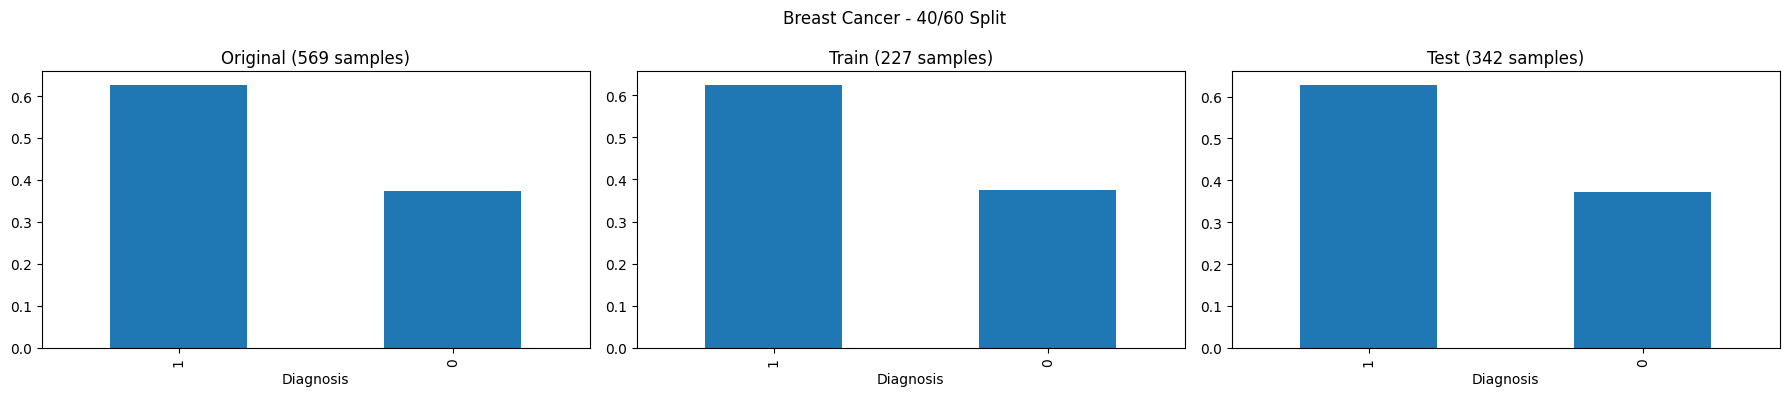

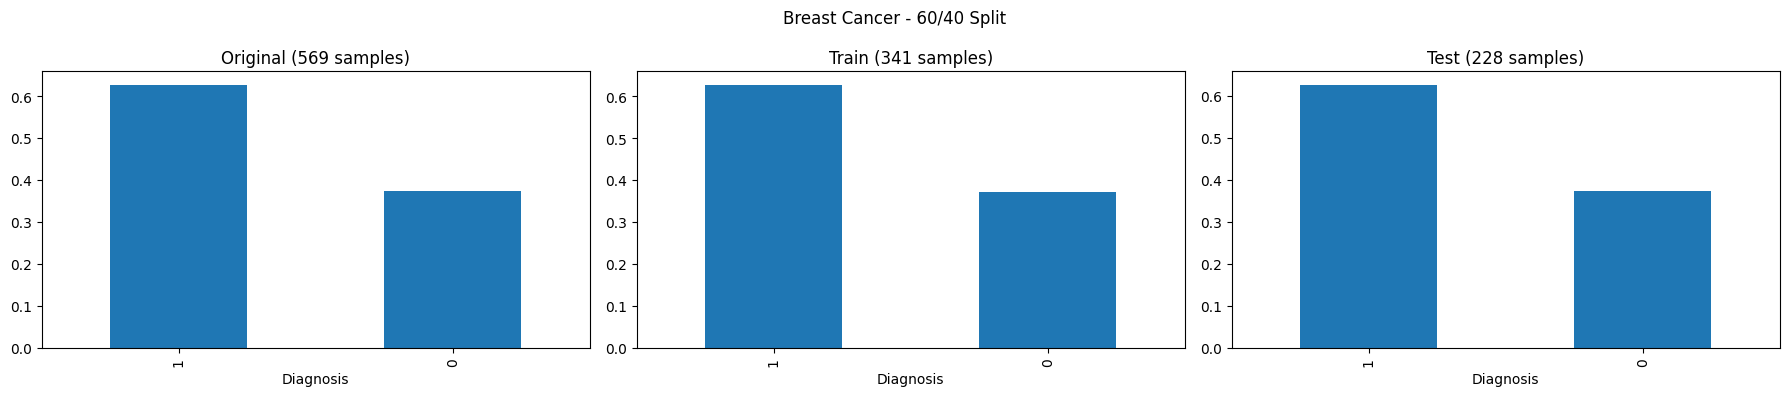

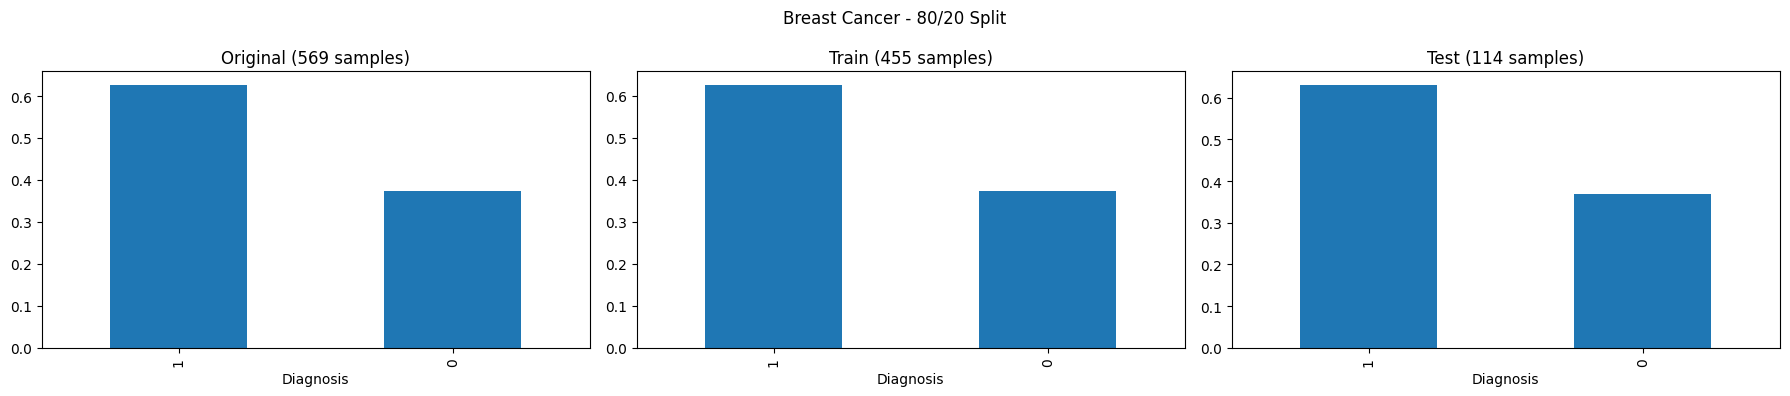

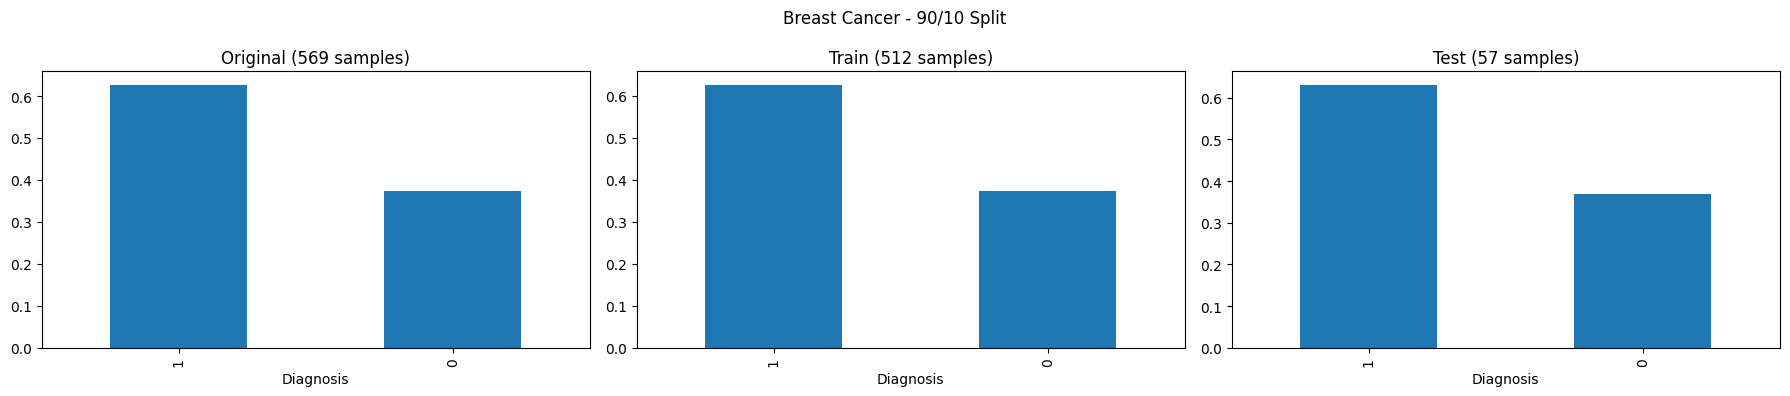


Classification Report (Breast Cancer, 80/20):
              precision    recall  f1-score   support

        High       0.60      0.59      0.60       265
         Low       0.38      0.43      0.41        46
    Standard       0.86      0.85      0.86       914

    accuracy                           0.78      1225
   macro avg       0.61      0.63      0.62      1225
weighted avg       0.78      0.78      0.78      1225



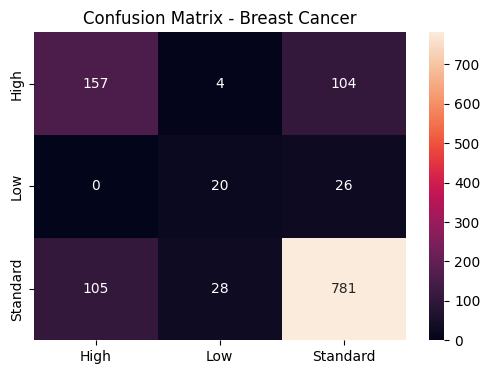

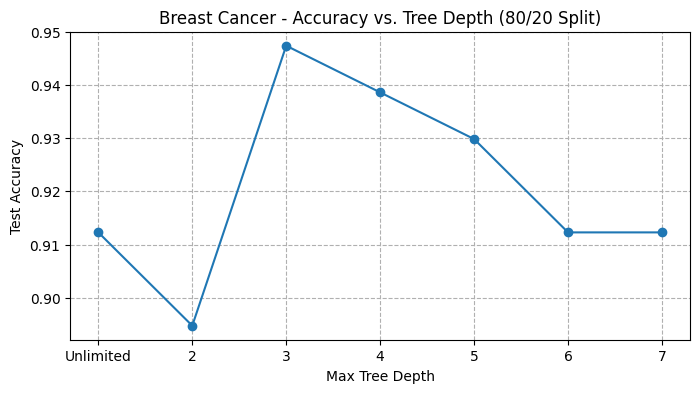

In [8]:
# Breast Cancer Dataset Example
split_and_visualize(X_breast, y_breast, "Breast Cancer")

# Load data and define names
feature_names = X_breast.columns.tolist()  # 30 features
class_names = ["Malignant", "Benign"]  # Must match y_breast.unique()

X_train, X_test, y_train, y_test = train_test_split(
    X_wine,
    y_wine,
    stratify=y_wine,  # Maintain class proportions
    random_state=42,
)

train_evaluate_decision_tree(
    X_train,
    y_train,
    X_test,
    y_test,
    "Breast Cancer",
    0.8,
)
depth_results = depth_accuracy_analysis(
    X_breast, y_breast, X_breast.columns, ["Malignant", "Benign"], "Breast Cancer"
)

# Repeat similarly for Wine and Car datasets
